In [ ]:
from local.torch_basics import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.all import *
from local.vision.core import *
from local.vision.augment import *

In [ ]:
path = untar_data(URLs.CAMVID)

In [ ]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [ ]:
def ListSplitter(valid_items):
    def _inner(items):
        val_mask = tensor([o.name in valid_items for o in items])
        return [~val_mask,val_mask]
    return _inner

In [ ]:
camvid = DataBlock(types=(PILImage, PILMask),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}')

In [ ]:
def rm_class(x): return torch.Tensor._make_subclass(Tensor, tensor(x))
rm_class.order=999

In [ ]:
dbunch = camvid.databunch(path/"images", bs=8, #item_tfms=Resize(sz), 
                          batch_tfms=[*aug_transforms(size=(360,480)), Normalize(*imagenet_stats)])

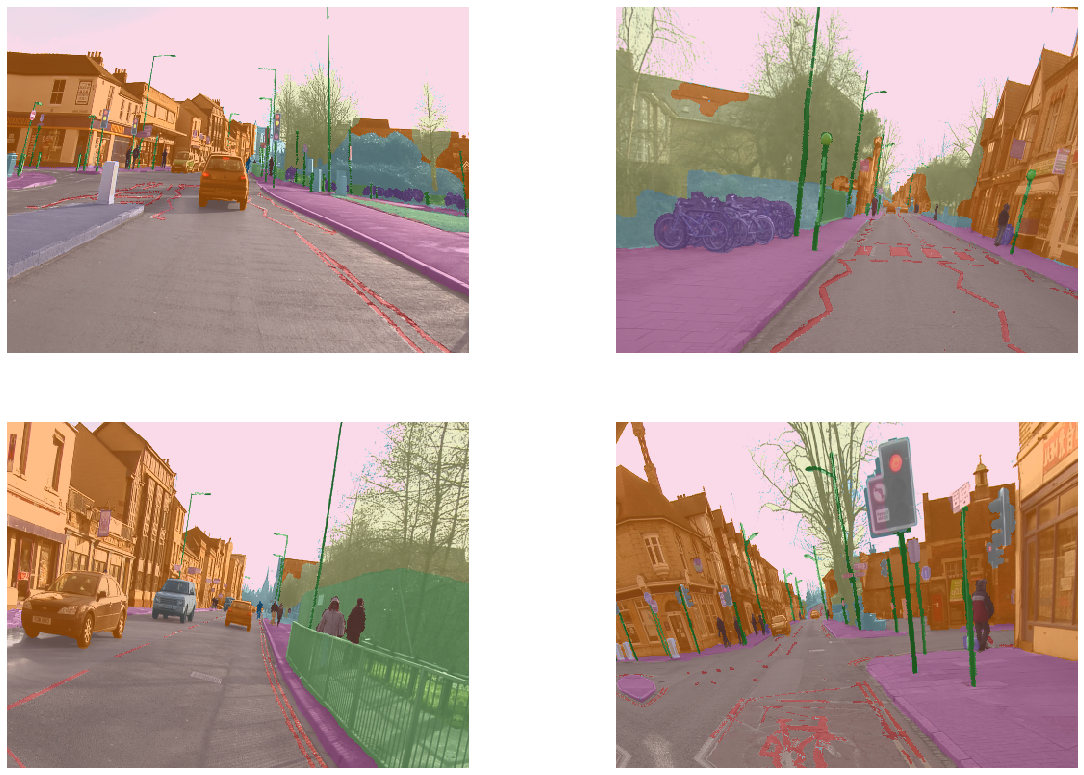

In [ ]:
dbunch.show_batch(max_n=4, vmin=1, vmax=30, figsize=(20, 14))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dbunch.vocab = codes

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

In [ ]:
#from fastai.vision import *

In [ ]:
#dbunch.c = len(codes)
#dbunch.path = path
#dbunch.empty_val=False
#learn = old_unet_learner(dbunch, resnet34, loss_func=CrossEntropyLossFlat(axis=1), path=path, wd=1e-2, metrics=acc_camvid)
#learn = unet_learner(dbunch, models.resnet34, loss_func=CrossEntropyLossFlat(axis=1), path=path, wd=1e-2, metrics=acc_camvid)

In [ ]:
#learn = Learner(dbunch, learn1.model, loss_func=CrossEntropyLossFlat(axis=1), path=path, opt_func=opt_func, metrics=acc_camvid, splitter=model_meta[resnet34]['split'])

In [ ]:
learn = unet_learner(dbunch, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid,
                     config = unet_config(norm_type=None), wd_bn_bias=True)

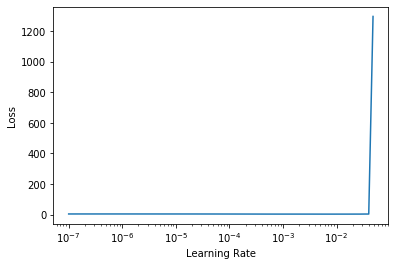

In [ ]:
learn.lr_find()

In [ ]:
lr= 3e-3
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')
learn.unfreeze()

In [ ]:
#learn.opt.clear_state() #Not necessarily useful

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=1e-2)

In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30, figsize=(15,6))